In [15]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

#df = pd.read_csv('./data/cleaned/wo_helsingfors/consumption_temp_w_features.csv')
df = pd.read_csv('./data/cleaned/consumption_temp_w_features.csv')


In [16]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import numpy as np

### Preprocessing data for linear regression

df['time'] = pd.to_datetime(df['time'])
df['time'] = df['time'].apply(lambda x: x.timestamp())


# Fill null values since linear regression can't deal
df['consumption_lag_last_week'].fillna(df['consumption'], inplace=True)
df['consumption_lag_5_days'].fillna(df['consumption'], inplace=True)
# df['consumption_ma_week'].fillna(df['consumption'], inplace=True)
# df['consumption_max_week'].fillna(df['consumption'], inplace=True)
# df['consumption_min_week'].fillna(df['consumption'], inplace=True)
# df['temperature_diff_prev_day'].fillna(df['temperature'], inplace=True)

# one-hot encode location
df_one_hot = pd.get_dummies(df['location'])

# join the one-hot encoded df with the original dataframe
df = pd.concat([df, df_one_hot], axis=1)

display(df.head(3))

# drop location which is now one-hot encoded, also date idk if its a useful
# feature
df.drop(['location', 'date'], axis=1, inplace=True)

df.to_csv('./data/preprocessed/lin_reg_preproccessed.csv', index=False)
#df.to_csv('./data/preprocessed/lin_reg_preproccessed_wo_helsingfors.csv', index=False)


,time,location,consumption,temperature,date,is_holiday,weekday,hour_of_day,weekday_hour,is_weekend,...,consumption_lag_5_days,season,holiday_season_winter,consumption_ewm_alpha_0.93,bergen,helsingfors,oslo,stavanger,tromsø,trondheim
0,1.649365e+09,bergen,1.113325,-0.3,2022-04-07,False,3,21,63,0,...,1.113325,1,0,1.113325,True,False,False,False,False,False
1,1.649365e+09,oslo,4.092830,1.0,2022-04-07,False,3,21,63,0,...,4.092830,1,0,4.092830,False,False,True,False,False,False
2,1.649365e+09,stavanger,2.057858,1.3,2022-04-07,False,3,21,63,0,...,2.057858,1,0,2.057858,False,False,False,True,False,False


In [17]:
# Original columns from ANEO timeset excluding consumption and location (one-
# hot encoded)
features = ['time','temperature']

# Added columns
# Can play around a bit with these:)
# old: 
# features += ['is_holiday','weekday','hour_of_day','consumption_lag_last_week','consumption_lag_5_days','season','temperature_diff_prev_day','consumption_ma_week','consumption_max_week','consumption_min_week','consumption_ewm_alpha_0.5','bergen','helsingfors','oslo','stavanger','tromsø','trondheim']
features += ['holiday_season_winter','weekday','hour_of_day','weekday_hour','is_weekend','consumption_lag_last_week','consumption_lag_5_days','season','consumption_ewm_alpha_0.93','bergen','oslo','helsingfors','stavanger','tromsø','trondheim']
# 01331024199265966
# 01331024199265966
# 007189064802326991
# 0013169707948864973
# 0006909019032737164
# 0005937596456187084
# 0005051510244250388
# 0003522551289551239
# 0002873620419598142
# 00022978991634481854
# 00017926748080057504
# 0001492651960923397
# 0003116337868939042
# 0.0003116337868939042 -- with Helsingfors

### W/O Helsingfors (predicting helsingfors)
# 0.0003510786734172369 < with technically

# Separate features and target

#X = df[features].values
#y = df['consumption'].values

# Shuffle = False since this a time-series data; we want to train on the past
# and test on future data
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=False)

X_train = df_train[features].values
y_train = df_train['consumption'].values

# Separate features and target for the test set
X_test = df_test[features].values
y_test = df_test['consumption'].values

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

regressor = LinearRegression()  
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
df_predictions = pd.DataFrame(y_pred, columns=['Predicted'])

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100


print("[prediction]")

# Calculate MAPE
predictive_mae = metrics.mean_absolute_error(y_test, y_pred)
predictive_mse = metrics.mean_squared_error(y_test, y_pred)
predictive_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
predictive_mape = mean_absolute_percentage_error(y_test, y_pred)

print('MAE: ', predictive_mae)  
print('MSE: ', predictive_mse)  
print('RMSE: ', predictive_rmse)
print(f'MAPE: {predictive_mape}%')

# Create the baseline list
baseline_last_week = df_test['consumption_lag_last_week'].tolist()

baseline_mae = metrics.mean_absolute_error(y_test, baseline_last_week)
baseline_mse = metrics.mean_squared_error(y_test, baseline_last_week)
baseline_rmse = np.sqrt(metrics.mean_squared_error(y_test, baseline_last_week))
baseline_mape = mean_absolute_percentage_error(y_test, baseline_last_week)

print()

print("[baseline for last week]")
print('MAE: ', baseline_mae)  
print('MSE: ', baseline_mse)  
print('RMSE: ', baseline_rmse)
print(f'MAPE: {baseline_mape}%')

# If our model's MSE is lower, its doiong better than predicting the mean every 
# time



# Some scores for different features:

# W/o last 5 days lagged feature but all other features included:
# Mean Absolute Error: 0.0703430708310453
# Mean Squared Error: 0.013756084315480399
# Root Mean Squared Error: 0.11728633473461603

# With both last week and 5 days lagged and all other features:
# Mean Absolute Error: 0.06956879391767189
# Mean Squared Error: 0.013346395589595678
# Root Mean Squared Error: 0.11552660122065254

# Can remove and add features to check performance...


[prediction]
MAE:  0.011094281588823604
MSE:  0.0003116337868939061
RMSE:  0.01765315232172164
MAPE: 0.20528671223519246%

[baseline for last week]
MAE:  0.46766686605633573
MSE:  0.5572787721495922
RMSE:  0.7465110663276145
MAPE: 8.991495513935902%


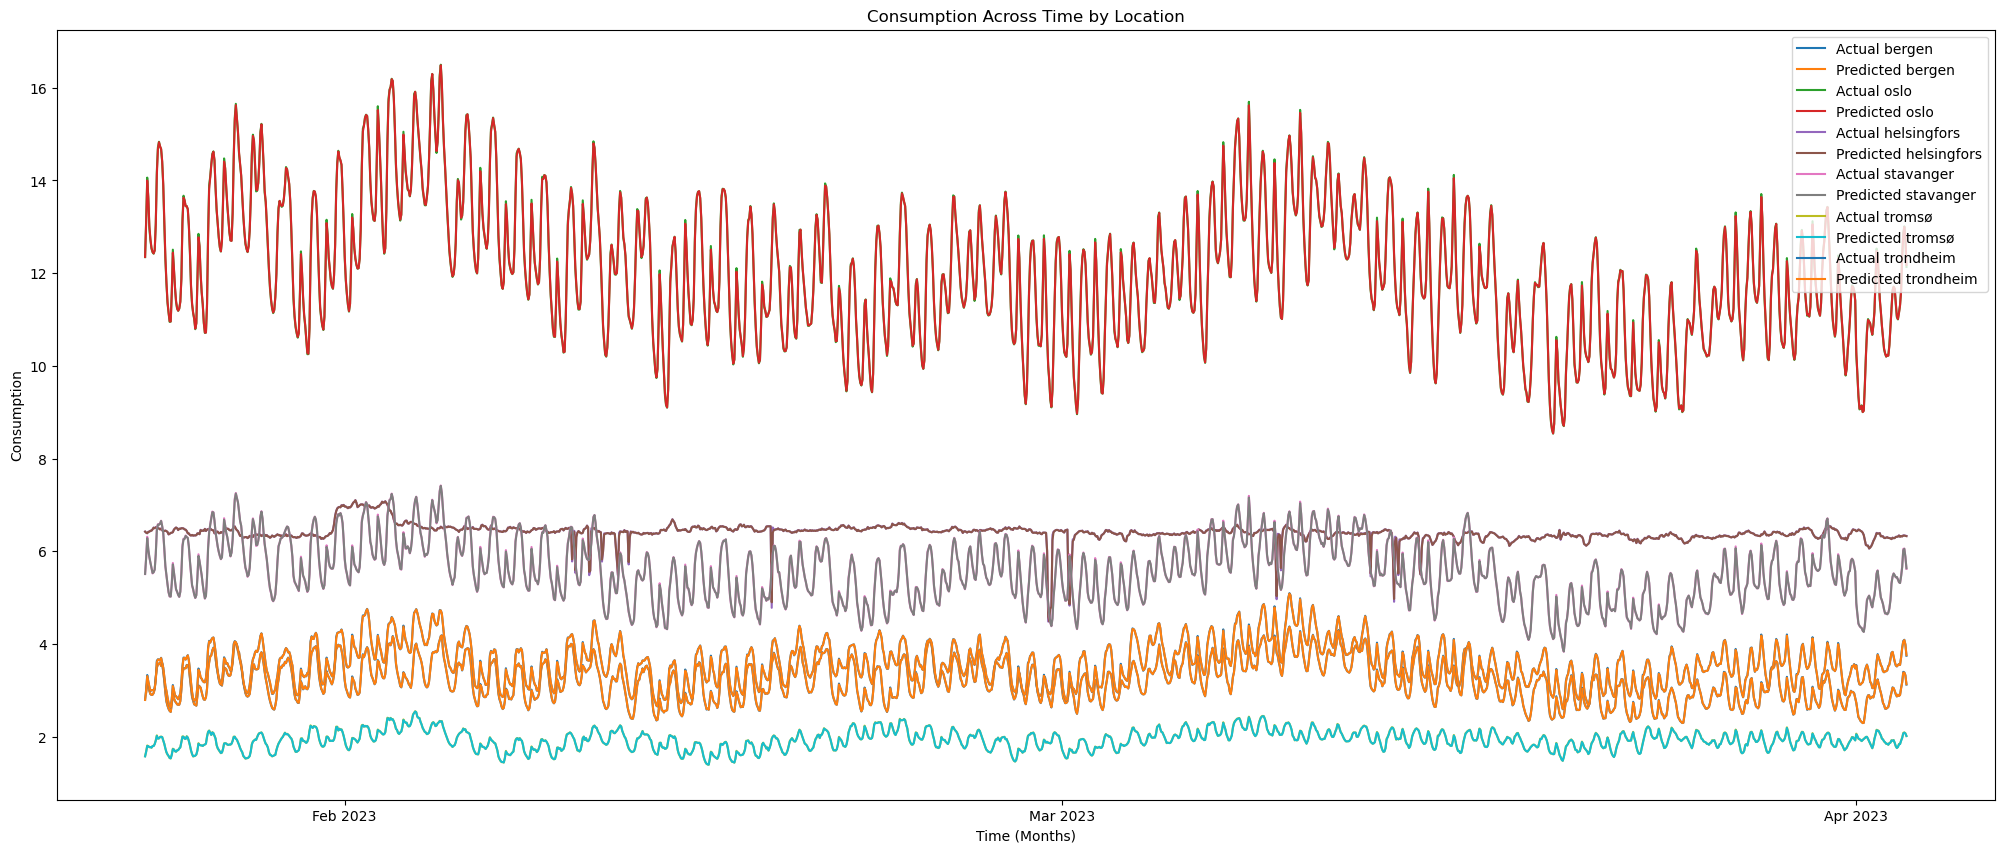

In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Create a figure and axis with larger size
fig, ax = plt.subplots(figsize=(25, 10))

# Convert X_test back into a DataFrame
X_test_df = pd.DataFrame(X_test, columns=features)

# Add 'y_test' and 'y_pred' to this DataFrame
X_test_df['Actual Consumption'] = y_test
X_test_df['Predicted Consumption'] = y_pred
X_test_df["Predicted Last Week"] = baseline_last_week


# Convert 'time' column back to datetime format
X_test_df['time'] = X_test_df['time'].apply(lambda x: datetime.fromtimestamp(x))

X_test_df.sort_values(by='time', inplace=True)

# List of locations
locations = ['bergen', 'oslo', 'helsingfors','stavanger', 'tromsø', 'trondheim']

# Loop through each location
for location in locations:
    # Filter data for the current location
    location_data = X_test_df[X_test_df[location] == 1]
    
    # Plot actual values for the current location
    ax.plot(location_data['time'], location_data['Actual Consumption'], label=f'Actual {location}')
    
    # Plot predicted values for the current location
    ax.plot(location_data['time'], location_data['Predicted Consumption'], label=f'Predicted {location}')
    

# Set the title and labels
ax.set_title('Consumption Across Time by Location')
ax.set_xlabel('Time (Months)')
ax.set_ylabel('Consumption')

# Format x-axis to show months
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Display the legend
ax.legend()

# Show the plot
plt.show()


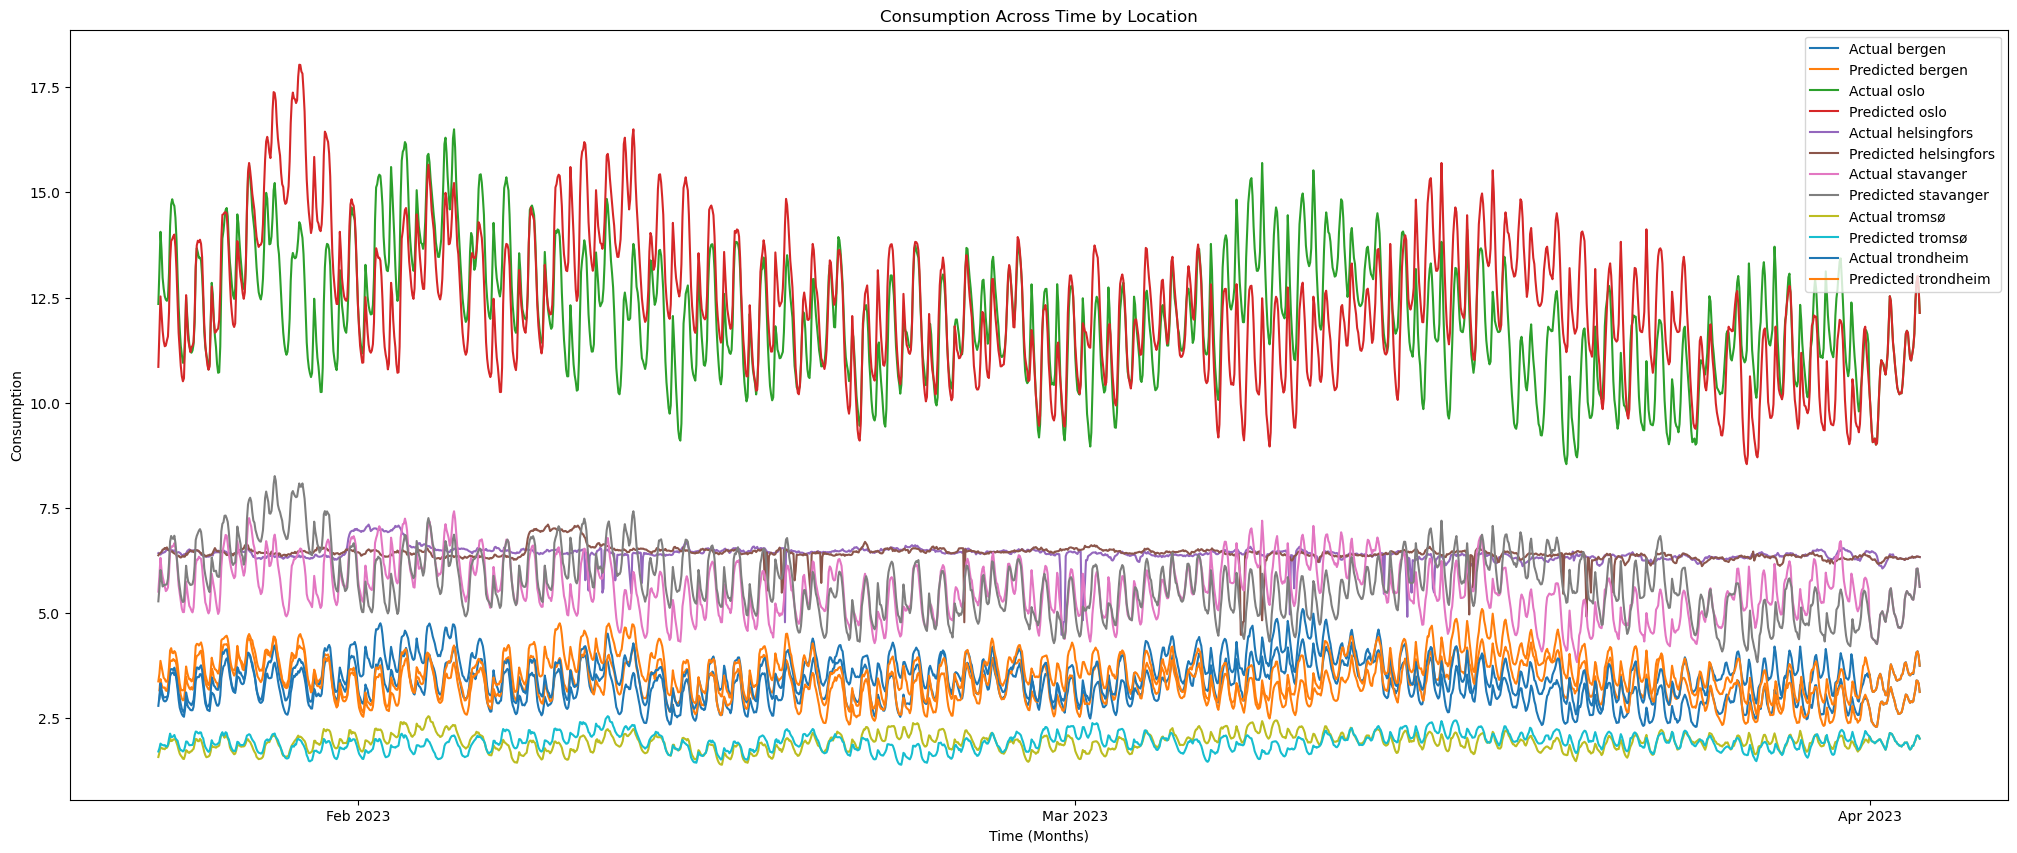

In [19]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Create a figure and axis with larger size
fig, ax = plt.subplots(figsize=(25, 10))

# Convert X_test back into a DataFrame
X_test_df = pd.DataFrame(X_test, columns=features)

# Add 'y_test' and 'y_pred' to this DataFrame
X_test_df['Actual Consumption'] = y_test
X_test_df['Predicted Consumption'] = y_pred
X_test_df["Predicted Last Week"] = baseline_last_week


# Convert 'time' column back to datetime format
X_test_df['time'] = X_test_df['time'].apply(lambda x: datetime.fromtimestamp(x))

X_test_df.sort_values(by='time', inplace=True)

# List of locations
locations = ['bergen', 'oslo', 'helsingfors', 'stavanger', 'tromsø', 'trondheim']

# Loop through each location
for location in locations:
    # Filter data for the current location
    location_data = X_test_df[X_test_df[location] == 1]
    
    # Plot actual values for the current location
    ax.plot(location_data['time'], location_data['Actual Consumption'], label=f'Actual {location}')
    
    # Plot predicted values for the current location
    ax.plot(location_data['time'], location_data['Predicted Last Week'], label=f'Predicted {location}')
    

# Set the title and labels
ax.set_title('Consumption Across Time by Location')
ax.set_xlabel('Time (Months)')
ax.set_ylabel('Consumption')

# Format x-axis to show months
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Display the legend
ax.legend()

# Show the plot
plt.show()


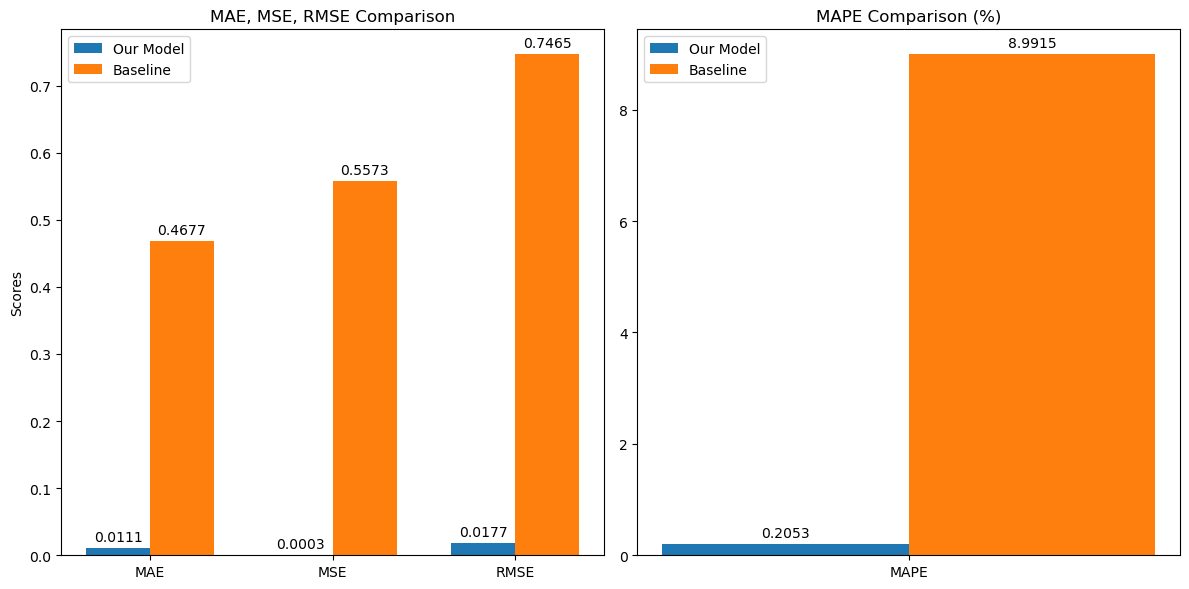

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics
metrics_1 = ['MAE', 'MSE', 'RMSE']
metrics_2 = ['MAPE']
our_model_1 = [predictive_mae, predictive_mse, predictive_rmse]
our_model_2 = [predictive_mape]
baseline_1 = [baseline_mae, baseline_mse, baseline_rmse]
baseline_2 = [baseline_mape]

x1 = np.arange(len(metrics_1))  # the label locations for first set of metrics
x2 = np.arange(len(metrics_2))  # the label locations for MAPE
width = 0.35  # the width of the bars

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Create two subplots

# First subplot
rects1_1 = ax1.bar(x1 - width/2, our_model_1, width, label='Our Model')
rects2_1 = ax1.bar(x1 + width/2, baseline_1, width, label='Baseline')
ax1.set_ylabel('Scores')
ax1.set_title('MAE, MSE, RMSE Comparison')
ax1.set_xticks(x1)
ax1.set_xticklabels(metrics_1)
ax1.legend()

# Second subplot
rects1_2 = ax2.bar(x2 - width/2, our_model_2, width, label='Our Model')
rects2_2 = ax2.bar(x2 + width/2, baseline_2, width, label='Baseline')
ax2.set_title('MAPE Comparison (%)')
ax2.set_xticks(x2)
ax2.set_xticklabels(metrics_2)
ax2.legend()

# Function to add labels
def bar_label(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

bar_label(rects1_1, ax1)
bar_label(rects2_1, ax1)
bar_label(rects1_2, ax2)
bar_label(rects2_2, ax2)

fig.tight_layout()
plt.show()


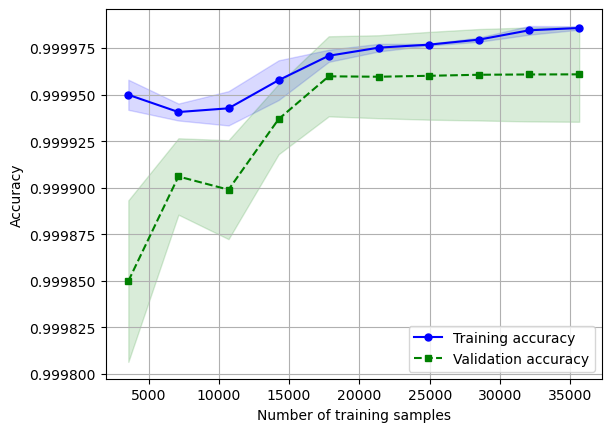

In [21]:
import numpy as np
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt


# Check for overfitting

train_sizes, train_scores, test_scores = learning_curve(estimator=regressor,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# We have an 80/20 split of train/test, meaning we have ~28,000 training samples
# and ~7,000 test samples. The learning curve shows that the training and
# validation accuracy are converging, which means that we are not overfitting
# the training data. If the training accuracy was much higher than the
# validation accuracy, then we would be overfitting the training data.
